<a href="https://colab.research.google.com/github/kpjaskie/SenSIP21/blob/main/Crystal_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Originally written by Google as a tutorial for the Cat vs. Dog Image Classification problem, this notebook has been converted into a classification solution to identify crystalline vs non-crystalline substances.

In [51]:
import os
import shutil
import zipfile

# To plot images and learning graphs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
import numpy as np
from sklearn.model_selection import train_test_split
from itertools import permutations


# Download the Data

The data needs to be available in a google drive account.  The following code will enable Colab to access that drive to get the data.

In [1]:
#@title Mount to Google
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
# grab and unzip image folder - make sure this is the correct folder where you have stored image zip!
# I saved the zip file in my drive, so this is where it was stored for me.
# This will be different for you!
local_zip = '/content/gdrive/My Drive/Images.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
 
zip_ref.extractall('/tmp/images/')  #Extracts to local '/tmp/images' 
zip_ref.close()

In [18]:
# gather images
image_dir = '/tmp/images/Images Machine Learning'

image_names_no = os.listdir(image_dir + '/No')
image_names_yes = os.listdir(image_dir + '/Yes')

num_images_no = len(os.listdir(image_dir + '/No'))
num_images_yes = len(os.listdir(image_dir + '/Yes'))

# verify correct file transfer and size of tranfer
print('Total No images :', num_images_no)
print('Total Yes images :', num_images_yes)

Total No images : 400
Total Yes images : 400


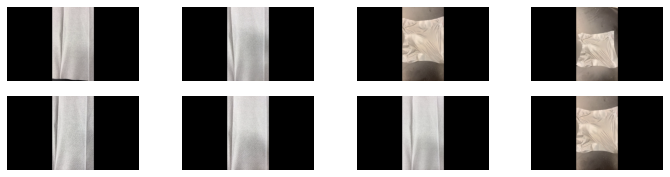

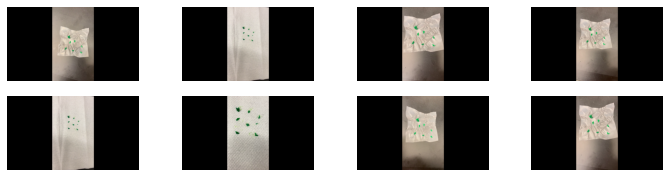

In [27]:
def show_images(images, image_dir):
  # visualize random 2x4 subset of images
  nrows = 2
  ncols = 4

  # Set up matplotlib fig, and size it to fit 
  fig = plt.gcf()
  fig.set_size_inches(ncols * 3, nrows * 1.5)

  # choose random images to display
  for i in range(nrows * ncols):
    pic_index = random.randint(0, len(images)-1)
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(os.path.join(image_dir, images[pic_index]))
    plt.imshow(img)

  plt.show()

show_images(image_names_no, image_dir + '/No')
show_images(image_names_yes, image_dir + '/Yes')

In [29]:
#@title Create Lables to match data
y_no = np.zeros((num_images_no, 1))
y_yes = np.ones((num_images_yes, 1))

In [50]:
#@title Helper Functions
empty = np.zeros((0,0))
def shuffle(x, y=empty):
  order = np.random.permutation(x.shape[0])
  x_shuffled = x[order,:]
  y_flag = False

  if y.shape[0] > 0:
    assert y.shape[0] == x.shape[0], 'Arrays must have the same length.'
    y_shuffled = y[order,:]
    y_flag = True

  #Accomodate different number of outputs
  if y_flag:
    return x_shuffled, y_shuffled
  else:
    return x_shuffled

# Create Training and Val Sets

In [66]:
#@title Combine all data and labels to create final dataset
Test_holdout = 0.2 #@param {type:"slider", min:0.1, max:0.5, step:0.01}
X_no_train, X_no_val, y_no_train, y_no_val = train_test_split(image_names_no, 
                                                    np.zeros((num_images_no, 1)), 
                                                    test_size=Test_holdout)

X_yes_train, X_yes_val, y_yes_train, y_yes_val = train_test_split(image_names_yes, 
                                                    np.ones((num_images_yes, 1)), 
                                                    test_size=Test_holdout)

# Create a new directory to hold training and validation data.  If the directories 
# already exist from previous runs, remove them and their contents first
train_data = '/tmp/images/train_data'
val_data = '/tmp/images/val_data'

if os.path.isdir(train_data):
    shutil.rmtree(train_data)
if os.path.isdir(val_data):
    shutil.rmtree(val_data)

# Everything is handled via file structure for this code so the files have to 
# all be in the correct folders for training and testing to occur properly
os.mkdir(train_data) 
os.mkdir(train_data + '/Yes')
os.mkdir(train_data + '/No')

os.mkdir(val_data)
os.mkdir(val_data + '/Yes')
os.mkdir(val_data + '/No')

# Move training and validation sets into their appropriate directories
for x in X_yes_train:  
    src = os.path.join(image_dir + '/Yes', x)
    dst = os.path.join(train_data + '/Yes', x)
    shutil.copyfile(src, dst)

for x in X_no_train:  
    src = os.path.join(image_dir + '/No', x)
    dst = os.path.join(train_data + '/No', x)
    shutil.copyfile(src, dst)

for x in X_yes_val:  
    src = os.path.join(image_dir + '/Yes', x)
    dst = os.path.join(val_data + '/Yes', x)
    shutil.copyfile(src, dst)

for x in X_no_val:  
    src = os.path.join(image_dir + '/No', x)
    dst = os.path.join(val_data + '/No', x)
    shutil.copyfile(src, dst)

## Building a Small Convnet

The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

**NOTE**: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples, using just three convolutional modules keeps the model small, which lowers the risk of overfitting

In [57]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [58]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [59]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

Let's summarize the model architecture:

In [60]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [62]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_data,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        val_data,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 640 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


### Training
Let's train on all available, for 15 epochs, and validate on all validation images. (This may take a few minutes to run.)

In [69]:
history = model.fit(
      train_generator,
      steps_per_epoch=32,  # X training images (640) = batch_size (20) * steps (32)
      epochs=15,
      validation_data=validation_generator,
      validation_steps=8,  # X validation images (160) = batch_size (20) * steps (8)
      verbose=2)

Epoch 1/15
32/32 - 17s - loss: 3.0024e-07 - acc: 1.0000 - val_loss: 3.3645e-07 - val_acc: 1.0000
Epoch 2/15
32/32 - 17s - loss: 1.5360e-07 - acc: 1.0000 - val_loss: 1.2284e-07 - val_acc: 1.0000
Epoch 3/15
32/32 - 17s - loss: 4.8690e-08 - acc: 1.0000 - val_loss: 4.8291e-08 - val_acc: 1.0000
Epoch 4/15
32/32 - 17s - loss: 1.2795e-08 - acc: 1.0000 - val_loss: 1.4837e-08 - val_acc: 1.0000
Epoch 5/15
32/32 - 17s - loss: 3.9447e-09 - acc: 1.0000 - val_loss: 7.4646e-09 - val_acc: 1.0000
Epoch 6/15
32/32 - 17s - loss: 1.3921e-09 - acc: 1.0000 - val_loss: 4.7878e-09 - val_acc: 1.0000
Epoch 7/15
32/32 - 17s - loss: 6.3529e-10 - acc: 1.0000 - val_loss: 7.4018e-09 - val_acc: 1.0000
Epoch 8/15
32/32 - 17s - loss: 3.7187e-10 - acc: 1.0000 - val_loss: 9.7351e-10 - val_acc: 1.0000
Epoch 9/15
32/32 - 17s - loss: 1.7896e-10 - acc: 1.0000 - val_loss: 3.9783e-09 - val_acc: 1.0000
Epoch 10/15
32/32 - 17s - loss: 6.0477e-10 - acc: 1.0000 - val_loss: 3.4154e-09 - val_acc: 1.0000
Epoch 11/15
32/32 - 17s - los

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


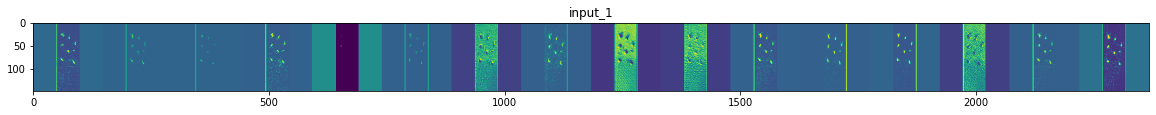

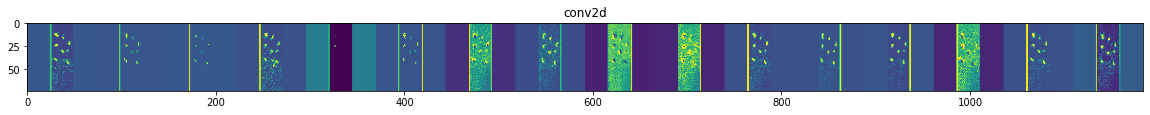

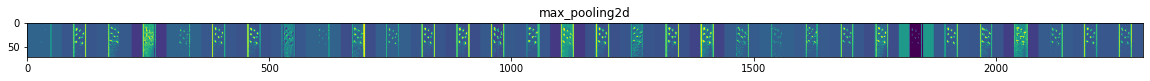

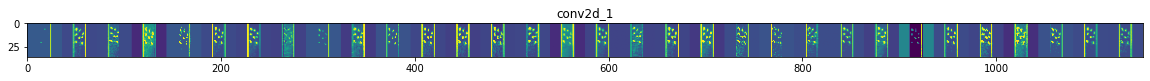

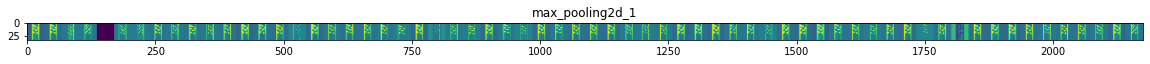

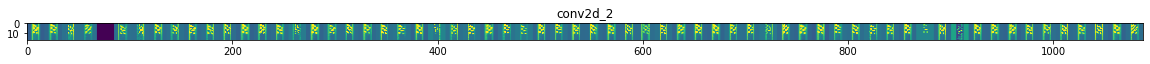

In [70]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a no or yes from the training set.
no_img_files = [os.path.join(train_data + '/No', f) for f in X_no_train]
yes_img_files = [os.path.join(train_data + '/Yes', f) for f in X_yes_train]
img_path = random.choice(no_img_files + yes_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

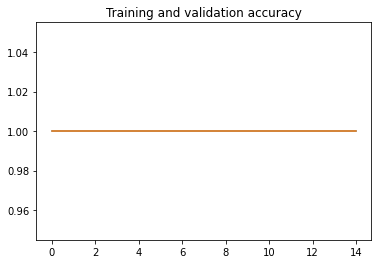

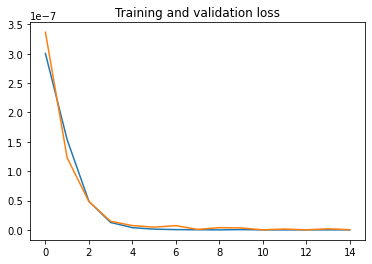

In [71]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

As both the training and validation accuracy and loss are effectively the same and so good, we know our model isn't overtraining or undertraining.  This is just a very easy problem for a neural network.  A NN is really overpowered for this problem.